In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
mido.Message(type='note_on').type

'note_on'

In [6]:
n = 500 * 2
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.MIDIFILE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data

Encoding midi-data
 1000
> -> multi-track = True MidiFile
 [INFO] : 
 |  True


In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

In [8]:
x_train.shape

(1000, 160, 7, 1)

In [9]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((1000, 160, 7, 1), 900)

In [10]:
x_test = x_train[m:]
x_train = x_train[:m]

m (50, 7)


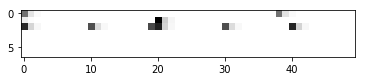

m (50, 7)


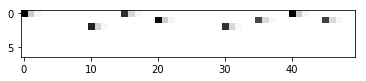

array(["../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid",
       '../datasets/drum_midi//50´s Drummer MIDI Files/06 Soul - Funk/08 Rim Soul 90BPM/01 4th Hat.mid'],
      dtype='<U125')

In [11]:
i = 0
j = 399
plot.single(x_train[i, :50,:,0])
plot.single(x_train[j, :50,:,0])
# plot.single(x_train[2, :50,:,0])
np.array(labels)[[i,j]]

In [12]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 7, 1)

In [13]:
latent_dim = 10
epsilon_std = 1.0

In [14]:
encoder_model, encoder_input, z_mean, z_log_var = models.encoder(input_shape, latent_dim)
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 7, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 160, 7)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 159, 64)      960         reshape_1[0][0]                  
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 256)          197632      conv1d_1[0][0]                   
__________________________________________________________________________________________________
z_mean (De

In [15]:
sample_ = lambda args: models.sample(args, z_mean, z_log_var, latent_dim, epsilon_std)

In [16]:
# z = Lambda(sampling)([z_mean, z_log_var])
z_input = encoder_model(encoder_input)
z_output = Lambda(sample_)(z_input)

In [17]:
decoders = models.list_decoders(input_shape)
decoded = utils.composition(decoders, z_output, verbose=False)

In [18]:
# instantiate VAE model
vae_input = encoder_input
vae_output = decoded
vae = Model(vae_input, vae_output)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 7, 1)    0                                            
__________________________________________________________________________________________________
encoder_model- (Model)          [(None, 10), (None,  203732      input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 10)           0           encoder_model-[1][0]             
                                                                 encoder_model-[1][1]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          2816        lambda_2[0][0]                   
__________

In [19]:
# vae.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [20]:
# TODO test hinge loss over mse
vae_loss = models.vae_loss(vae_input, vae_output, z_mean, z_log_var, timesteps, notes, beta=0.75, gamma=0.05)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
# vae.compile(optimizer=optimizer, loss=loss, metrics=metrics)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Output "reshape_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_2" during training.
  after removing the cwd from sys.path.


In [21]:
K.int_shape(z_mean)

(None, 10)

In [22]:
batch_size = 128
epochs = 500
params = {'batch_size': batch_size, 'return_y': False}

In [23]:
phase_mod = 0.01
whitening = False

In [24]:
m = 1000
useDataGenerator = False
# useDataGenerator = True
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

x = x_train[:m]
# x = x_train
# i = [0,1, 7,8, 14,15, 399,400]
# x = x_train[i]
# x = np.concatenate([x for _ in range(10)])
print('x:', x.shape)

print('batch_size: %i' % batch_size)
print('update-iterations:', round(epochs * x.shape[0] / batch_size))
if useDataGenerator:
    datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
    history = collections.defaultdict(list)
    n_batches = datagen.__len__()
    for e in range(epochs):
        print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
        for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
            print(' Batch %i/%i' % (batch_i,n_batches))
            x_ = x_batch
            # x_ = datagen.shuffle_3rd_dim(x_)
            # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
            h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
            for k,v in h.history.items(): 
                print(' \\_%s' % k, [round(v_,) for v_ in v])
                history[k].append(v)
            if batch_i >= n_batches:
                break
else:
    h = vae.fit(x, epochs=epochs, validation_data=(x_test, None), callbacks=callbacks)
    history = h.history

x: (900, 160, 7, 1)
batch_size: 128
update-iterations: 3516
Train on 900 samples, validate on 100 samples
Epoch 1/500
900/900 [==============================] - 13s 15ms/step - loss: 382.8540 - val_loss: 82.4481
Epoch 2/500
900/900 [==============================] - 14s 15ms/step - loss: 129.1081 - val_loss: 77.1622
Epoch 3/500
900/900 [==============================] - 13s 15ms/step - loss: 122.5264 - val_loss: 76.8940
Epoch 4/500
900/900 [==============================] - 12s 13ms/step - loss: 121.4268 - val_loss: 75.8488
Epoch 5/500
900/900 [==============================] - 17s 19ms/step - loss: 120.8375 - val_loss: 77.5613
Epoch 6/500
900/900 [==============================] - 21s 24ms/step - loss: 120.0698 - val_loss: 76.5324
Epoch 7/500
900/900 [==============================] - 15s 17ms/step - loss: 119.3815 - val_loss: 76.7832
Epoch 8/500
900/900 [==============================] - 13s 15ms/step - loss: 118.8528 - val_loss: 75.4291
Epoch 9/500
900/900 [=========================

Epoch 154/500
900/900 [==============================] - 11s 12ms/step - loss: 76.3804 - val_loss: 57.2118
Epoch 155/500
900/900 [==============================] - 11s 12ms/step - loss: 77.9162 - val_loss: 57.3459
Epoch 156/500
900/900 [==============================] - 11s 12ms/step - loss: 77.1407 - val_loss: 55.8914
Epoch 157/500
900/900 [==============================] - 11s 12ms/step - loss: 76.1445 - val_loss: 57.7464
Epoch 158/500
900/900 [==============================] - 11s 12ms/step - loss: 76.4931 - val_loss: 56.5930
Epoch 159/500
900/900 [==============================] - 11s 12ms/step - loss: 76.2181 - val_loss: 56.3171
Epoch 160/500
900/900 [==============================] - 11s 12ms/step - loss: 76.2162 - val_loss: 56.2390
Epoch 161/500
900/900 [==============================] - 11s 12ms/step - loss: 75.7624 - val_loss: 57.2301
Epoch 162/500
900/900 [==============================] - 11s 12ms/step - loss: 75.6048 - val_loss: 56.0662
Epoch 163/500
900/900 [==============

900/900 [==============================] - 11s 12ms/step - loss: 71.5782 - val_loss: 58.4718
Epoch 307/500
900/900 [==============================] - 11s 12ms/step - loss: 71.6258 - val_loss: 58.1327
Epoch 308/500
900/900 [==============================] - 11s 12ms/step - loss: 70.8455 - val_loss: 57.5518
Epoch 309/500
900/900 [==============================] - 11s 12ms/step - loss: 71.5852 - val_loss: 58.1002
Epoch 310/500
900/900 [==============================] - 11s 12ms/step - loss: 72.9859 - val_loss: 57.5871
Epoch 311/500
900/900 [==============================] - 11s 12ms/step - loss: 71.6138 - val_loss: 57.7243
Epoch 312/500
900/900 [==============================] - 11s 12ms/step - loss: 70.5828 - val_loss: 57.6527
Epoch 313/500
900/900 [==============================] - 11s 12ms/step - loss: 70.1575 - val_loss: 58.5856
Epoch 314/500
900/900 [==============================] - 11s 12ms/step - loss: 70.1480 - val_loss: 57.2692
Epoch 315/500
900/900 [============================

900/900 [==============================] - 12s 13ms/step - loss: 66.4109 - val_loss: 59.1035
Epoch 459/500
900/900 [==============================] - 12s 13ms/step - loss: 65.4486 - val_loss: 58.8259
Epoch 460/500
900/900 [==============================] - 12s 13ms/step - loss: 66.1094 - val_loss: 59.3885
Epoch 461/500
900/900 [==============================] - 12s 13ms/step - loss: 67.2518 - val_loss: 59.8463
Epoch 462/500
900/900 [==============================] - 12s 13ms/step - loss: 66.3620 - val_loss: 59.2521
Epoch 463/500
900/900 [==============================] - 12s 13ms/step - loss: 66.1788 - val_loss: 58.9552
Epoch 464/500
900/900 [==============================] - 12s 13ms/step - loss: 65.8150 - val_loss: 58.9225
Epoch 465/500
900/900 [==============================] - 12s 13ms/step - loss: 65.7828 - val_loss: 59.8331
Epoch 466/500
900/900 [==============================] - 11s 13ms/step - loss: 65.7161 - val_loss: 58.2113
Epoch 467/500
900/900 [============================

In [77]:
# io.save_dict(history)
io.save_dict('../logs/','train_loss', history)

'../logs/train_loss.csv'

(0, 150)

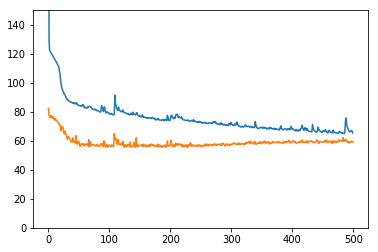

In [143]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.ylim(0,150)

In [28]:
fn = config.model_dir + 'hi_res2c_vae.h5'

In [29]:
# for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
#     model.save_weights(dn + prefix + suffix + '.h5', "w")
vae.save_weights(fn, "w")

In [30]:
# vae.load_weights(fn)

In [31]:
# vae2 = vae

In [32]:
x.shape

(900, 160, 7, 1)

m (50, 7, 1)


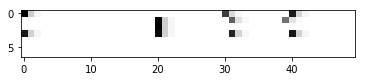

m (50, 7, 1)


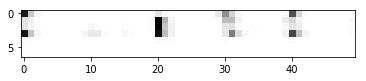

m (50, 7, 1)


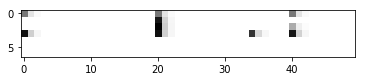

m (50, 7, 1)


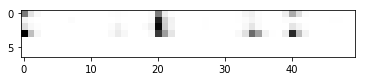

In [33]:
i = 240
j = 30
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [34]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [35]:
x.shape

(900, 160, 7, 1)

m (30, 7)


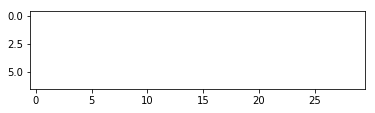

In [36]:
# min: these pixels are 'always' active
m = x.min(axis=0)
plot.multi(m[:30,:,0])

m (30, 7)


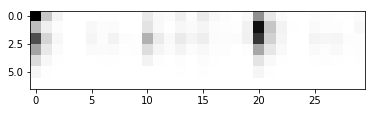

In [37]:
# mean
m = x.mean(axis=0)
plot.single(m[:30,:,0])

## Encoder + Decoder (generator)
A model to project inputs on the latent space

In [38]:
# build a model to project inputs on the latent space
encoder = Model(encoder_input, z_mean)

In [39]:
generator_input = Input((latent_dim,))
generator_layers_ = utils.composition(decoders, generator_input)
generator = Model(generator_input, generator_layers_)

In [40]:
decoder = generator

## Save models to disk
(requires h5py)

In [41]:
# models_io.save_model(vae, dn + prefix + '_vae')
# models_io.save_model(encoder, dn + prefix + '_encoder')
# models_io.save_model(generators, dn + prefix + '_generator')

## Style transfer

In [42]:
m = 100
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(100, 10)

original
m (160, 7, 1)


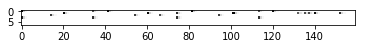

(11, 160, 7, 1) [-0.03212225  0.5110927  -0.02210356 -0.02667776  0.399894  ]
identity
m (160, 7, 1)


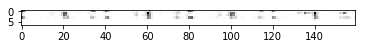

mutations
m (160, 7, 1)


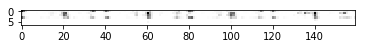

m (160, 7, 1)


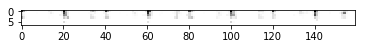

m (160, 7, 1)


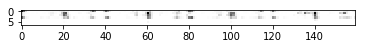

m (160, 7, 1)


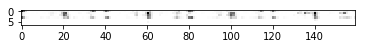

In [43]:
i = 100
amt = 0.3
print('original')
plot.single(x_train[i])
z = encoder.predict(x_train[i:i+1])
zs = [ z[0].copy() for _ in range(latent_dim) ]
for i,z_ in enumerate(zs):
    z_[i] = z_[i] + amt
generated = decoder.predict(np.concatenate([z[:1], zs]))
print(generated.shape, z[0,:5])
print('identity')
plot.single(generated[0]) 
print('mutations')
plot.single(generated[1])
plot.single(generated[2])
plot.single(generated[3])
plot.single(generated[4])

In [44]:
mido.MidiFile()

<midi file None type 1, 0 tracks, 0 messages>

In [45]:
# utils.clear_dir(config.export_dir)
for i, sample in enumerate(generated):
    s = midi.MultiTrack.from_array(sample)
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'generated-' + str(i))

 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8802083333333335
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0


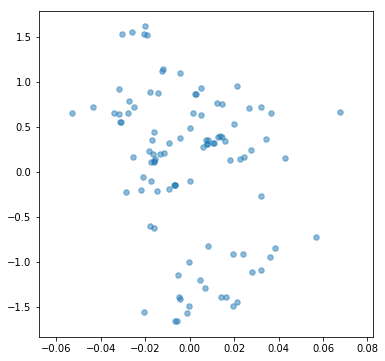

In [46]:
# y_test = range(x_train_encoded.shape[0])
y_test = np.concatenate([list(range(n)) for _ in range(int(m/n)+1)])[:m] / n
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], alpha=0.5, s=30) # c=y_test, 

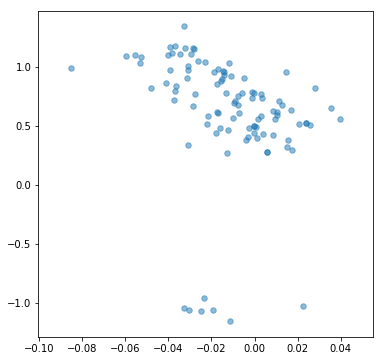

In [47]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], alpha=0.5, s=30) # , c=y_test
# plt.colorbar()

In [48]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_decoded = utils.composition(decoders, decoder_input, verbose=False)
generator = Model(decoder_input, _decoded)

In [49]:
# x_decoded[0].reshape(150,3)

In [50]:
x_train.shape

(900, 160, 7, 1)

(10,) [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


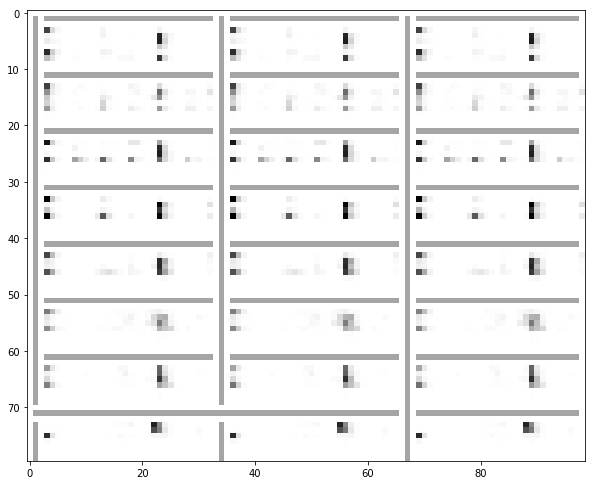

In [51]:
min_y = 0.01
max_y = 0.5
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,
       n=8,
       m=3,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y,
       max_y=max_y)

(10,) [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


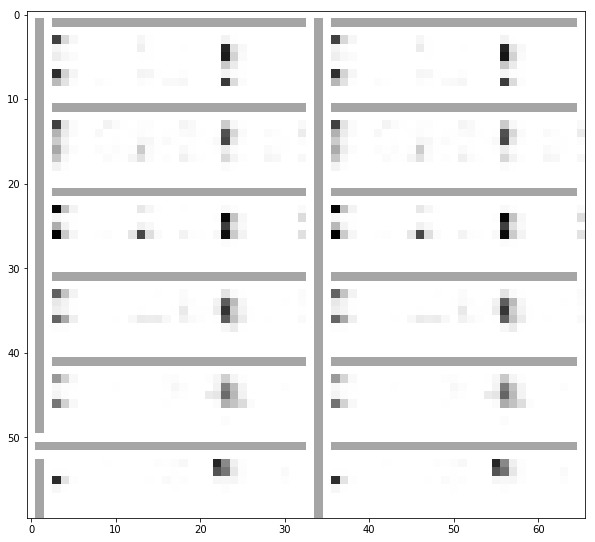

In [52]:
min_y2 = max_y
plot.latent(generator, batch_size, latent_dim,
       x_encoded=0.5,            
       n=6,
       m=2,
       crop_size=30,
       margin_top=1,
       margin_left=1,
       min_x=0.05,
       max_x=0.95,
       min_y=min_y2,
       max_y=0.95)

In [53]:
a = [0,11,100,399]
# utils.clear_dir(config.export_dir)
for i in a:
    s = midi.MultiTrack.from_array(x_train[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_true_' + str(i))
    
    s = midi.MultiTrack.from_array(y[i])
    mid = midi.decode.track(context, s, transpose=0)
    io.export_midifile(mid, config.export_dir + 'y_pred' + str(i))    

 [INFO] : 
 |  len, max_t
 |  3.8052083333333324
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8052083333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.530208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.830208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.880208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9052083333333334
 |  4.0


# Style transfer
rock ~ funk

In [54]:
[(a,b) for a,b in enumerate(labels)]

[(0,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../

../datasets/drum_midi//50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM/01 8th Snare.mid ../datasets/drum_midi//50´s Drummer MIDI Files/03 Traditional Pop/01 Fly High 115BPM/01 8th Hat.mid ../datasets/drum_midi//50´s Drummer MIDI Files/02 Blues/06 Vidar Vega 70BPM/01 8th Hat.mid
m (80, 7, 1)


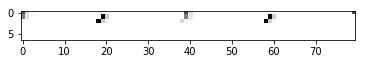

m (80, 7, 1)


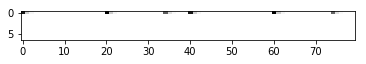

m (80, 7, 1)


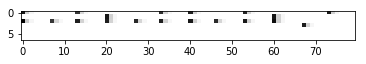

In [55]:
i,j,k = 21, 140, 105 # 210, 79
m = 80
sample_size = 10
print(labels[i], labels[j], labels[k])
plot.single(x_train[i,:m])
plot.single(x_train[j,:m])
plot.single(x_train[k,:m])

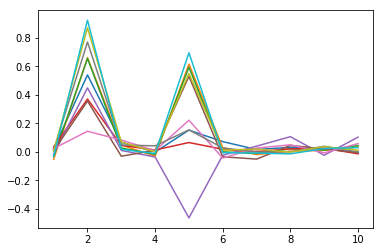

In [56]:
latent_vectors = encoder.predict(x_train[:250])
indices = np.arange(latent_vectors.shape[-1]) + 1
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + i])
# plt.ylim((-1,1))

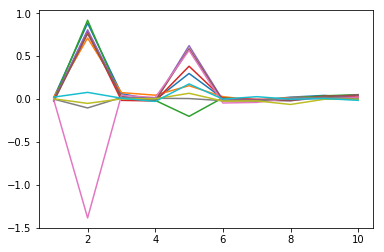

In [57]:
for l in range(sample_size):
    plt.plot(indices, latent_vectors[l + j])
# plt.ylim((-1,1))

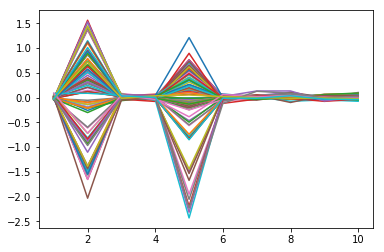

In [58]:
indices = np.arange(latent_vectors.shape[-1]) + 1
for l in range(100):
    plt.plot(indices, latent_vectors[l + i])
# plt.ylim((-1,1))

In [59]:
a = x_train[i:i+sample_size]
b = x_train[j:j+sample_size]
c = x_train[k:k+sample_size]

In [60]:
t = models.extract_transformation(encoder, a, b)
t

array([ 0.0007751 , -0.2351079 , -0.01292452, -0.00247545, -0.04654321,
       -0.01178874, -0.01487502, -0.03123147,  0.00481375, -0.0053086 ],
      dtype=float32)

m (80, 7, 1)


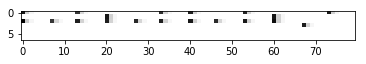

m (80, 7, 1)


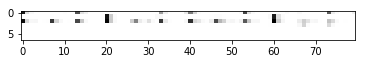

In [61]:
c_ = models.transfer_style(encoder, generator, a, b, c)
plot.single(c[0,:m])
plot.single(c_[0,:m])

In [62]:
d = {'original':c, 'generated':c_, 'a':a, 'b':b}
for name,v in d.items():
    mid = midi.decode.track(context, v[0], name=name)
    mid.tracks[0].name = name
    io.export_midifile(mid, config.export_dir + 'style_transfer-' + name)

 [INFO] : 
 |  len, max_t
 |  3.8552083333333336
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8552083333333336
 |  4.0
 [INFO] : 
 |  len, max_t
 |  4.005208333333333
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.8802083333333335
 |  4.0


In [63]:
from sklearn.decomposition import PCA
# http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
# It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009,
# depending on the shape of the input data and the number of components to extract.

In [64]:
pca = PCA(n_components=3)

In [65]:
pca_result = pca.fit_transform(latent_vectors)
pca_result.shape

(250, 3)

In [66]:
[round(v,3) for v in pca.explained_variance_ratio_], round(sum(pca.explained_variance_ratio_[:2]),2)

([0.58, 0.415, 0.001], 0.99)

In [67]:
pca.components_

array([[ 7.6725089e-05, -4.2648277e-01, -5.5921441e-03,  1.2160303e-03,
         9.0445930e-01,  5.3979165e-04, -2.8306355e-03, -4.6867216e-03,
        -1.3364715e-03, -1.1558962e-03],
       [ 9.1125173e-03, -9.0426749e-01, -2.9201745e-03,  3.6057965e-03,
        -4.2638978e-01,  4.1046063e-03,  1.6456848e-02, -7.5419736e-04,
        -5.7709683e-03, -8.1214113e-03],
       [-1.0904907e-01,  1.2932724e-02,  1.9088475e-01,  3.3840251e-01,
         5.2391961e-03,  5.4590583e-01,  3.8387856e-01, -2.8285652e-01,
        -2.4546573e-01, -5.0132185e-01]], dtype=float32)

In [68]:
pca.singular_values_

array([13.809529 , 11.682612 ,  0.6897452], dtype=float32)

2 best dims


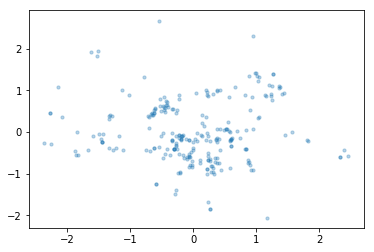

In [69]:
print('2 best dims')
plt.scatter(pca_result[:,0], pca_result[:,1], alpha=0.3, s=10) # c=labels
# plt.ylim((-1,1))

2 best dims, 3 classes


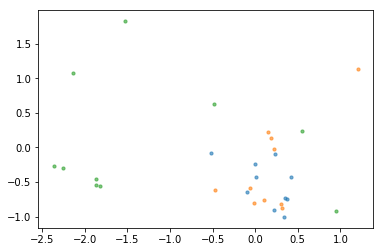

In [70]:
print('2 best dims, 3 classes')
for i_ in [i,j,k]:
    plt.scatter(pca_result[i_:i_+sample_size,0], pca_result[i_:i_+sample_size,1], alpha=0.6, s=10) # c=labels
# plt.ylim((-1,1))

In [71]:
# import ggplot
# chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
#         + geom_point(size=75,alpha=0.8) \
#         + ggtitle("First and Second Principal Components colored by digit")
# chart

In [72]:
from sklearn.manifold import TSNE

In [73]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)

In [74]:
# TODO shuffle data?
tsne_results = tsne.fit_transform(latent_vectors)
tsne_results.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.005s...
[t-SNE] Computed neighbors for 250 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 0.300324
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.346466
[t-SNE] Error after 500 iterations: 0.204620


(250, 2)

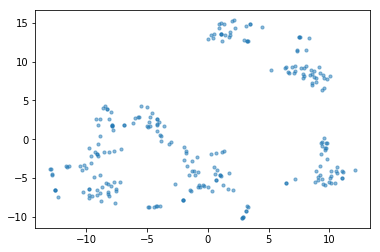

In [75]:
plt.scatter(tsne_results[:,0], tsne_results[:,1], alpha=0.5, s=10)

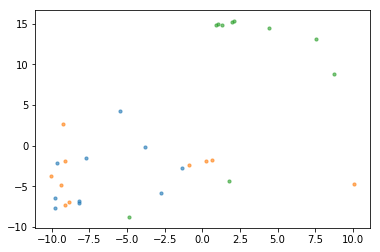

In [76]:
for i_ in [i,j,k]:
    plt.scatter(tsne_results[i_:i_+sample_size,0], tsne_results[i_:i_+sample_size,1], alpha=0.6, s=10) # c=labels
# plt.ylim((-1,1))